In [1]:
import pickle
import glob

import tensorflow as tf
import numpy as np

In [2]:
def load_data(pattern, num_batches=None):
    data = []
    labels = []
    for filename in glob.glob(pattern):
        batch = pickle.load(open(filename, 'rb'), encoding='bytes')
        data.append(batch[b'data'])
        labels.append(np.array(batch[b'labels']))
    data = np.concatenate(data)
    data = np.transpose(np.reshape(data, [-1, 3, 32, 32]), [0, 2, 3, 1])
    labels = np.concatenate(labels)
    if num_batches:
        data = np.split(data, num_batches)
        labels = np.split(labels, num_batches)
    return data, labels

In [3]:
def conv(x, name, num_filters=64, filter_size=3, stride=1, is_output=False):
    with tf.name_scope(name):
        num_chans = x.get_shape()[-1]
        W = tf.get_variable(name+'_W', shape=(filter_size, filter_size, num_chans, num_filters))
        b = tf.get_variable(name+'_b', shape=(num_filters,))

        op = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')
        op = tf.nn.bias_add(op, b)
        if not is_output:
            op = tf.nn.relu(op)
        return op

In [4]:
def fc(x, name, out_size=50, is_output=False):
    with tf.name_scope(name):
        in_size = x.get_shape()[-1]
        W = tf.get_variable(name+'_W', shape=(in_size, out_size))
        b = tf.get_variable(name+'_b', shape=(out_size,))
        
        op = tf.matmul(x, W)
        op = tf.nn.bias_add(op, b)
        if not is_output:
            op = tf.nn.relu(op)
        return op

In [5]:
def layer(fn, *args, **kwargs):
    return lambda x: fn(x, *args, **kwargs)


def network(x, y, layers, learning_rate=1e-4):
    for layer in layers:
        x = layer(x)

    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=x, labels=y))
    accuracy = tf.contrib.metrics.accuracy(tf.argmax(x, axis=1), y, name='accuracy')
    train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return loss, accuracy, train

In [6]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='x')
y = tf.placeholder(tf.int64, (None,), name='y')
layers = [
    layer(conv, name='C0'),
    layer(conv, stride=2, name='C1'),
    layer(tf.contrib.layers.flatten, scope='flatten'),
    layer(fc, name='F0'),
    layer(fc, out_size=10, is_output=True, name='F1'),
]
loss, accuracy, train = network(x, y, layers)

In [7]:
def get_summary(name):
    loss_summary = tf.summary.scalar(name+'_loss', loss)
    accuracy_summary = tf.summary.scalar(name+'_accuracy', accuracy)
    return tf.summary.merge([loss_summary, accuracy_summary])

train_summary, test_summary = get_summary('train'), get_summary('test')

In [8]:
# I use all the data, with the standard train/test split
# For efficiency, I use 500 mini-batches, with 100 examples per mini-batch.
train_data, train_labels = load_data('cifar-10-batches-py/data_batch_*', 500)
test_data, test_labels = load_data('cifar-10-batches-py/test_batch')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('tf_logs', sess.graph)
        
    step = 0
    while step < 5000: # 10 passes through the entire training data
        for data, labels in zip(train_data, train_labels):
            _, ss = sess.run([train, train_summary], feed_dict={x: data, y: labels})
            writer.add_summary(ss, step)
            
            ss = sess.run(test_summary, feed_dict={x: test_data, y: test_labels})
            writer.add_summary(ss, step)
                    
            writer.flush()
            step+=1
    
    writer.close()

In [9]:
from IPython.display import Image

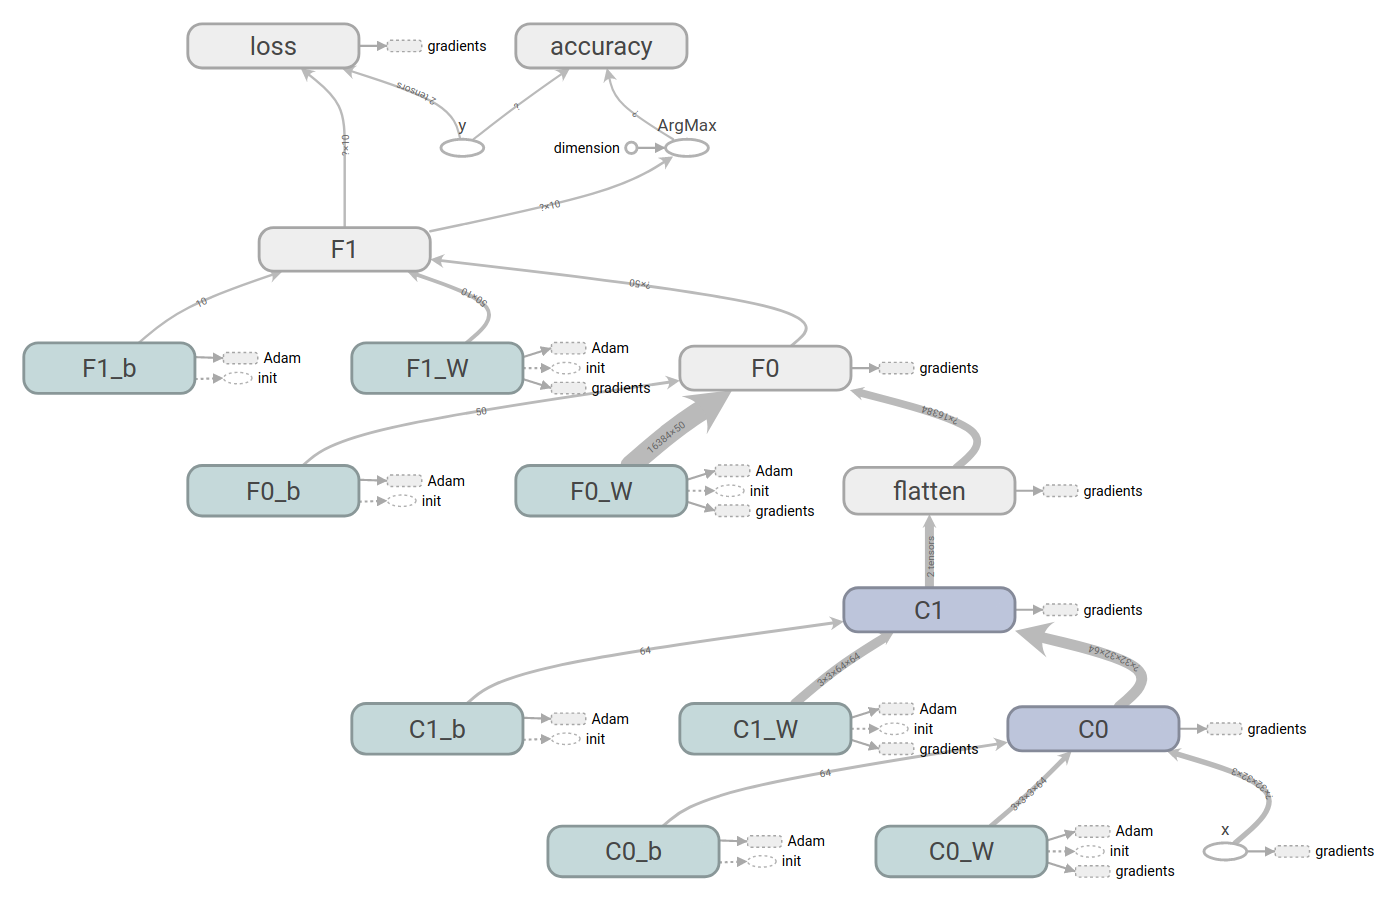

In [10]:
Image('graph.png')

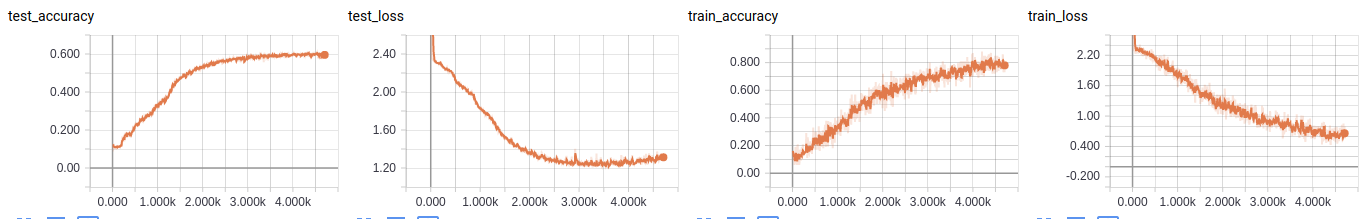

In [11]:
Image('plots.png')